Analyzing serial neurogym results

In [6]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

class Args():
    def __init__(self):
        self.exp_name = 'gates_search'
        self.var1 = 1
        self.var2 = 0.1
        self.same_rnn = True
        self.use_gates = True
        self.train_to_criterion = True
        self.num_of_tasks = 15
args = Args() 

exp_name = args.exp_name
os.makedirs('./files/'+exp_name, exist_ok=True)

###--------------------------Training configs--------------------------###

# set device
device = 'cuda' # always CPU
# Config
config = {
    # exp:
    'exp_name': exp_name,
    # envs
    'tasks': ['yang19.dlygo-v0',
            'yang19.rtgo-v0',
            'yang19.dlyanti-v0',
            'yang19.go-v0',
            'yang19.dms-v0',
            'yang19.dnms-v0',
            'yang19.dmc-v0',
            'yang19.dnmc-v0',
            'yang19.dm1-v0',
            'yang19.dm2-v0',
            'yang19.ctxdm1-v0',
            'yang19.ctxdm2-v0',
            'yang19.multidm-v0',
            'yang19.anti-v0',
            'yang19.rtanti-v0'
            ],
    'env_kwargs': {'dt': 100},
    'seq_len': 50,
# Training
    'trials_per_task' : 200000,
    'batch_size' : 100,
    'print_every_batches': 100,
    'train_to_criterion': bool(args.train_to_criterion),
    'device': device,
# model
    'use_lstm': False,
    'same_rnn' : bool(args.same_rnn), 
    'use_gates': bool(args.use_gates), 
    'md_mean' : args.var1,
    'md_range': args.var2, #0.1
    'use_external_inputs_mask': False,
    'input_size': 33,
    'hidden_size': 256,
    'sub_size': 128,
    'output_size': 17,
    'num_task': 2,
    'MDeffect': False,
    'md_size': 15,
    'md_active_size': 5,
    'md_dt': 0.001,
# optimizer
    'lr': 1e-4, # 1e-4 for CTRNN, 1e-3 for LSTM
}
config.update({'tasks': config['tasks'][:args.num_of_tasks]})
config.update({'human_task_names': ['{:<6}'.format(tn[7:-3]) for tn in config['tasks']]})
config.update({'md_size': len(config['tasks'])})

exp_signature = config['exp_name'] +f'_{args.var1}_{args.var2}_'+\
    f'{"same_rnn" if config["same_rnn"] else "separate"}_{"gates" if config["use_gates"] else "nogates"}'+\
        f'_{"tc" if config["train_to_criterion"] else "nc"}'
print(exp_signature)

task_seq = []
# Add tasks gradually with rehearsal 1 2 1 2 3 1 2 3 4 ...
task_sub_seqs = [[(i, config['tasks'][i]) for i in range(s)] for s in range(2, len(config['tasks']))] # interleave tasks and add one task at a time
for sub_seq in task_sub_seqs: task_seq+=sub_seq

# Just sequence the tasks serially
simplified_task_seq = [(i, config['tasks'][i]) for i in range(len(config['tasks']))]
task_seq = simplified_task_seq
# print('Task seq to be learned: ', task_seq)


gates_search_1_0.1_same_rnn_gates_tc


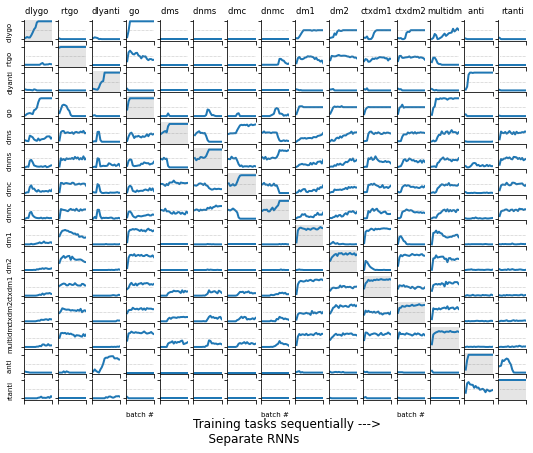

In [52]:
# one fig
file1= './files/gates_search/testing_logs_gates_search_1.0_0.1_same_rnn_gates_nc.npy'
file2= './files/same_rnn/testing_logs.npy'
file3= './files/separate_rnns/testing_logs.npy'

# label1 = 'no gates'
# label2 = 'with gates \u03bc(1, 0.1)'
label = 'Separate RNNs'
# label = 'Same RNN'

testing_logs = np.load( file3, allow_pickle=True)
logs = testing_logs

num_tasks = len(config['tasks'])
title_label = 'Training tasks sequentially ---> \n    ' + label 
plt.close('all')
max_x = config['trials_per_task']//config['batch_size']
fig, axes = plt.subplots(num_tasks,num_tasks, figsize=[9,7])
for logi in range(num_tasks):
    for li in range(num_tasks):
        ax = axes[ li, logi ] # log i goes to the col direction -->
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0, max_x])
#         ax.axis('off')
        log = testing_logs[logi]
        ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2)
        ax.plot(log['stamps'], np.ones_like(log['stamps'])*0.5, ':', color='grey', linewidth=0.5)
        if li == 0: ax.set_title(config['human_task_names'][logi])
        if logi == 0: ax.set_ylabel(config['human_task_names'][li])
        ax.set_yticklabels([]) 
        ax.set_xticklabels([])
        if logi== li:
            ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
        if li == num_tasks-1 and logi in [num_tasks//2 - 4, num_tasks//2, num_tasks//2 + 4] :
            ax.set_xlabel('batch #')
axes[num_tasks-1, num_tasks//2-2].text(-8., -2.5, title_label, fontsize=12)     
# exp_parameters = f'Exp parameters: {config["exp_name"]}\nRNN: {"same" if config["same_rnn"] else "separate"}\n\
#       mul_gate: {"True" if config["use_gates"] else "False"}\
#           {exp_signature}'
# axes[num_tasks-1, 0].text(-7., -2.2, exp_parameters, fontsize=7)
# plt.show(fig)
plt.savefig('./files/'+label+'_all_logs.png', dpi=300)


In [40]:

file1= './files/gates_search/testing_logs_gates_search_1.0_0.1_same_rnn_gates_nc.npy'
file2= './files/same_rnn/testing_logs.npy'
file3= './files/separate_rnns/testing_logs.npy'

# label1 = 'sep RNNs'
# label2 = 'same RNN'

label1 = 'no gates'
label2 = 'with gates \u03bc(1, 0.1)'

testing_logs1 = np.load( file2, allow_pickle=True)
testing_logs2 = np.load( file1, allow_pickle=True)

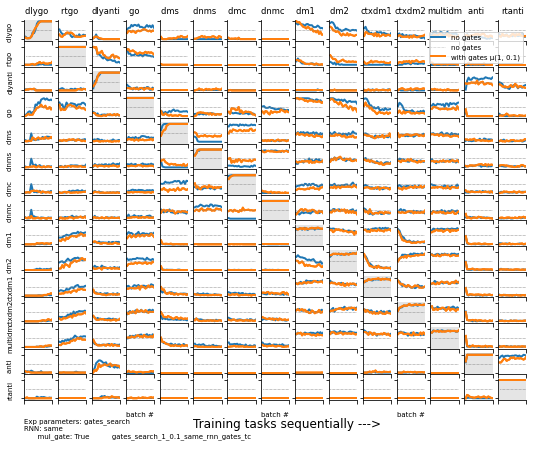

In [43]:
# two figs 
plt.close('all')
logs = testing_logs1
num_tasks = len(config['tasks'])
title_label = 'Training tasks sequentially ---> \n    ' #+ config['exp_name']
max_x = config['trials_per_task']//config['batch_size']
fig, axes = plt.subplots(num_tasks,num_tasks, figsize=[9,7])
for logi in range(num_tasks):
    for li in range(num_tasks):
        ax = axes[ li, logi ] # log i goes to the col direction -->
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0, max_x])
#         ax.axis('off')
        log = testing_logs1[logi]
        ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2, label=label1)
        ax.plot(log['stamps'], np.ones_like(log['stamps'])*0.5, ':', color='grey', linewidth=0.5, label=label1)
        if True:
            log = testing_logs2[logi]
            ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2, color='tab:orange', label=label2)

        if li == 0: ax.set_title(config['human_task_names'][logi])
            
        if logi == 0: ax.set_ylabel(config['human_task_names'][li])
        ax.set_yticklabels([]) 
        ax.set_xticklabels([])
        if logi== li:
            ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
        if li == num_tasks-1 and logi in [num_tasks//2 - 4, num_tasks//2, num_tasks//2 + 4] :
            ax.set_xlabel('batch #')
axes[1, num_tasks-1].legend()

for logi in range(num_tasks):
    for li in range(num_tasks):
        ax = axes[ li, logi ] # log i goes to the col direction -->
        log = testing_logs2[logi]
        ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2)
        ax.plot(log['stamps'], np.ones_like(log['stamps'])*0.5, ':', color='grey', linewidth=0.5)

        
axes[num_tasks-1, num_tasks//2-2].text(-8., -2.5, title_label, fontsize=12)     
# exp_parameters = f'Exp parameters: {config["exp_name"]}\nRNN: {"same" if config["same_rnn"] else "separate"}\n\
#       mul_gate: {"True" if config["use_gates"] else "False"}\
#           {exp_signature}'
axes[num_tasks-1, 0].text(-7., -2.2, exp_parameters, fontsize=7)
# plt.show(fig)
plt.savefig(f'./files/{label1}_vs_{label2}.png', dpi=300)

In [44]:
def extract_accuracies(logs):
    train = []
    test = []
    num_tasks = len(logs)
    for logi in range(num_tasks):
        for task_i in range(num_tasks):
            log = logs[logi]
            if logi== task_i:
                train.append(np.array([t[task_i] for t in logs[logi]['accuracy']]))
    #                 log['accuracy']task_i])
            else:
                test.append(np.array([t[task_i] for t in logs[logi]['accuracy']]))
    return(np.stack(train), np.stack(test))


# def get_np_acc(logs, num_tasks):
#     logs_tasks_tests_acc = []
#     for logi in range(len(logs)):
#         test_accuracies = []
#         for task_i in range(num_tasks):
#             test_accuracies.append([t[task_i] for t in logs[logi]['accuracy']])
#         logs_tasks_tests_acc.append(np.stack(test_accuracies))

#     ltta = np.stack(logs_tasks_tests_acc)
#     return(ltta)


# tr_acc = get_np_acc(train, 15)
# te_acc = get_np_acc(test, 15)

In [45]:
tr1, te1 = extract_accuracies(testing_logs1)
tr2, te2 = extract_accuracies(testing_logs2)


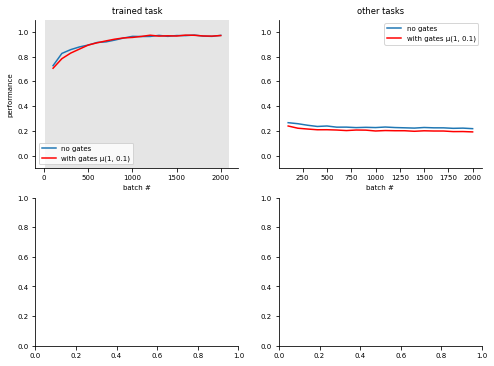

In [48]:
fig, axes = plt.subplots(2,2, figsize=(8,6))
ax = axes[0,0]
ax.set_title('trained task')
ax.plot(testing_logs1[0]['stamps'], tr1.mean(axis=(0)), label=label1)
ax.plot(testing_logs2[0]['stamps'], tr2.mean(axis=(0)), color='red', label=label2)
ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
ax.set_ylim([-0.1, 1.1])
ax.set_ylabel('performance')
ax.set_xlabel('batch #')
ax.legend()

ax = axes[0,1]
ax.set_title('other tasks')
ax.plot(testing_logs1[0]['stamps'], te1.mean(axis=(0)), label=label1)
ax.plot(testing_logs2[0]['stamps'], te2.mean(axis=(0)), color= 'red', label=label2)
ax.set_xlabel('batch #')
ax.legend()

ax.set_ylim([-0.1, 1.1])
# fig.savefig('./files/gates_no_gates_comp.jpg')
fig.savefig(f'./files/{label1}_{label2}comp.png', dpi=600)

In [94]:
with_gates_te = te_acc
with_gates_tr = tr_acc

(15, 20)
(210, 20)


TypeError: unsupported operand type(s) for +: 'collections.defaultdict' and 'collections.defaultdict'

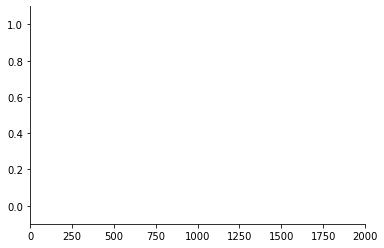

In [16]:

fig, ax = plt.subplots(1)
logs = testing_logs

train = []
test = []
for logi in range(num_tasks):
    for li in range(num_tasks):
        log = testing_logs[logi]
        if logi== li:
            train.append(logs[logi]['accuracy'])
        else:
            test.append(logs[logi]['accuracy'])

    
            
train = np.stack(train)
test = np.stack(test)
print(train.shape)
print(test.shape)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0, max_x])
ax.plot(log['stamps'], train.mean(axis=0), linewidth=2)
ax.plot(log['stamps'], test.mean(axis=0), color='grey', linewidth=2)
# if li == 0: ax.set_title(config['human_task_names'][logi])
# if logi == 0: ax.set_ylabel(config['human_task_names'][li])
ax.set_yticklabels([]) 
ax.set_xticklabels([])
        
ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
if li == num_tasks-1 and logi in [num_tasks//2 - 4, num_tasks//2, num_tasks//2 + 4] :
    ax.set_xlabel('batch #')


In [23]:
np.stack(train[0][0].values())

/om2/user/ahummos/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


array([0.08, 0.  , 0.03, 0.01, 0.03, 0.  , 0.03, 0.05, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.07, 0.02], dtype=float32)

In [24]:
logs[0]['accuracy']

[defaultdict(None,
             {0: array(0.08, dtype=float32),
              1: array(0., dtype=float32),
              2: array(0.03, dtype=float32),
              3: array(0.01, dtype=float32),
              4: array(0.03, dtype=float32),
              5: array(0., dtype=float32),
              6: array(0.03, dtype=float32),
              7: array(0.05, dtype=float32),
              8: array(0., dtype=float32),
              9: array(0., dtype=float32),
              10: array(0., dtype=float32),
              11: array(0., dtype=float32),
              12: array(0., dtype=float32),
              13: array(0.07, dtype=float32),
              14: array(0.02, dtype=float32)}),
 defaultdict(None,
             {0: array(0.04, dtype=float32),
              1: array(0., dtype=float32),
              2: array(0.05, dtype=float32),
              3: array(0.06, dtype=float32),
              4: array(0.02, dtype=float32),
              5: array(0.02, dtype=float32),
              6: array(0.0

In [31]:
test_accuracies = []
for task_i in range(15):
    test_accuracies.append([test[task_i] for test in logs[0]['accuracy']])


In [32]:
ta = np.stack(test_accuracies)

In [34]:

ta.shape

(15, 20)

In [35]:
ta

array([[0.08      , 0.04      , 0.06      , 0.05      , 0.14      ,
        0.28      , 0.48      , 0.64      , 0.72999996, 0.88      ,
        0.96      , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.03      ,
        0.05      , 0.        , 0.02      , 0.07      , 0.09999999,
        0.16      , 0.08      , 0.11      , 0.12      , 0.06      ,
        0.07      , 0.06      , 0.09999999, 0.09      , 0.17999999],
       [0.03      , 0.05      , 0.05      , 0.08      , 0.07      ,
        0.07      , 0.09999999, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.01      , 0.06      , 0.13      , 0.06      , 0.07      ,
        0.08      , 0.24      , 0.34      , 0.47      , 0.48      ,
        0.53      , 0.64      , 0.52      , 0

In [ ]:
task_i = 0
zz= zip(log['stamps'], [test[task_i] for test in logs[0]['accuracy']])

In [30]:
[print( (z, a)) for z, a in zz]

(100, array(0.08, dtype=float32))
(200, array(0.04, dtype=float32))
(300, array(0.06, dtype=float32))
(400, array(0.05, dtype=float32))
(500, array(0.14, dtype=float32))
(600, array(0.28, dtype=float32))
(700, array(0.48, dtype=float32))
(800, array(0.64, dtype=float32))
(900, array(0.72999996, dtype=float32))
(1000, array(0.88, dtype=float32))
(1100, array(0.96, dtype=float32))
(1200, array(1., dtype=float32))
(1300, array(1., dtype=float32))
(1400, array(1., dtype=float32))
(1500, array(1., dtype=float32))
(1600, array(1., dtype=float32))
(1700, array(1., dtype=float32))
(1800, array(1., dtype=float32))
(1900, array(1., dtype=float32))
(2000, array(1., dtype=float32))


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]